# Image Inpainting with Cheff

This notebook exhibits how image inpainting can be done with the Cheff model.

In [1]:
import os
os.chdir('..')

import torch
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

## Load Cheff LDM

For inpainting, the same standard LDM models can be used.

In [2]:
from cheff import CheffLDM

device = 'cuda'
sdm_path = 'trained_models/cheff_diff_uncond.pt'
ae_path = 'trained_models/cheff_autoencoder.pt'

cheff_ldm = CheffLDM(model_path=sdm_path, ae_path=ae_path, device=device)

## Load Image

The input image is expected to be 256x256px.  

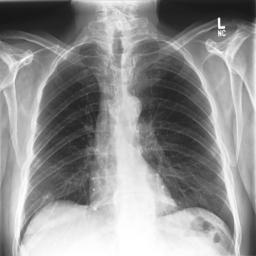

In [3]:
from torchvision.transforms.functional import to_tensor, to_grayscale
from PIL import Image

img = Image.open('assets/example_xray.jpg')
display(img)

img = to_tensor(img).to(device)
img = img * 2 - 1

# The LDM model expects 3 channel inputs
if img.shape[0] == 1:
    img = img.expand(3, -1, -1)

## Create Mask

The mask needs to be a binary array, which can be loaded from an image file or in our case generated manually.
Here, we task the model to fill the array in the black square.

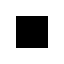

In [4]:
mask = torch.ones((64, 64))
mask[16:48, 16:48] = 0
mask = mask.float().to(device)

display(to_pil_image(mask))

## Run Model

To see different variations of the inpainting process, we transform and display the sample image a few times.

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|██████████| 100/100 [00:26<00:00,  3.82it/s]


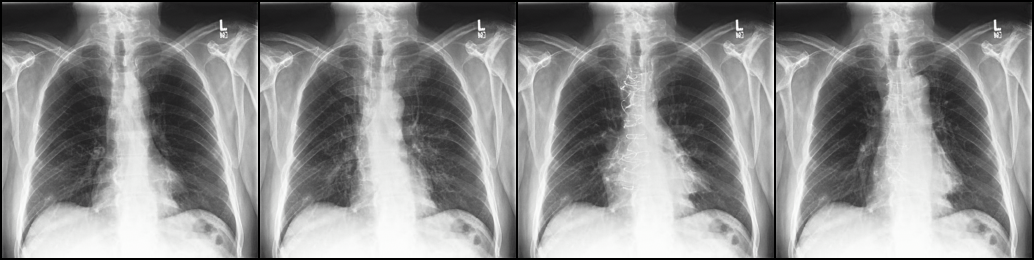

In [5]:
imgs = img.unsqueeze(0).expand(4, -1, -1, -1)
masks = mask.unsqueeze(0).unsqueeze(0).expand(4, -1, -1, -1)

imgs_edited = cheff_ldm.sample_inpaint(
    target_img=imgs,
    mask=masks,
    sampling_steps=100,
)

imgs_edited.clamp_(-1, 1)
imgs_edited = (imgs_edited + 1) / 2

img_grid = make_grid(imgs_edited.cpu())
display(to_pil_image(img_grid))

Alternatively, the model can be tasked to fill the area outside of the square by inverting the mask.

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


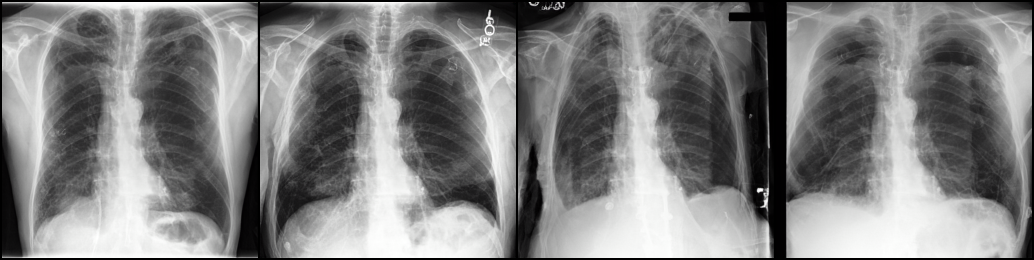

In [6]:
imgs_edited = cheff_ldm.sample_inpaint(
    target_img=imgs,
    mask=1 - masks,
    sampling_steps=100,
)

imgs_edited.clamp_(-1, 1)
imgs_edited = (imgs_edited + 1) / 2

img_grid = make_grid(imgs_edited.cpu())
display(to_pil_image(img_grid))